# QC inspection of: "The broccoli-derived antioxidant sulforaphane changes the growth of gastrointestinal microbiota, allowing for the production of anti-inflammatory metabolites*"

\[*\]:https://doi.org/10.1016/j.jff.2023.105645

Simple proteomics experiment, 8 batches of E. coli grown in two groups of media, measured with QExactive+, label-free quantitative analysis with MQ followed. As a bonus, the publication also has a related metabolomics experiment.

We will use this experiment to highlight how one could approach a simple post-hoc QC process using mzQC and the described implementation libraries. Here, we will focus not on the quality metrics applied, since those are outside the design-scope of the mzQC-libraries and implemented for this manuscript in concise scripts only to lend the demonstration an approachable context. `<Ref. GitHub repo for manuscript><Ref. format manuscript for QC metrics>` 
Instead, we will use the described process to highlight -from different angles- the ease of generating, handling, and benefitting from QC data.

On a side note, yet important to highlight, it's always good to have a look at the data from the raw side of things first. Like so, we discovered two raw files of the experiment, EG1 and EG2, to be damaged during file transmission and deposition in PRIDE archive. This was fixed by contacting the authors who reshared the files for an easy recovery to the dataset. 

## Methods
LSF batched: 1. raw conversion with ThermoRawFileParser, 2. Identification with Ecoli K12 Uniprot proteome database and comet, 3. mzQC construction from mzML/mzid input, demonstrating the use of the libraries. 
The construction of the mzQC files was done with the Java, R, and Python mzQC library implementations, each creating QC data for a different set of metrics from peak data access as common with the respective language. `<Table with metrics implemented><The individual library implementation details>`. 
(Any preparatory work was done as with the previous datasets, yet different fasta for identification.)

A workflow was designed to resmeble a common post-hoc QC process one might employ when investigating a new dataset. 
Motivation: This is common for multiple scenarios 
- planning a new experiment that bases on knowledge derived from previous publications, so data from these previous publication gets independently validated if not directly integrated into a greater analysis with new data 
- collecting data for meta-analysis projects
- publication review or while facing contradictory results from a related experiment
-> And thus the quality of data for that purpose needs to be investigated.

The metrics are created with simplicity and ease of use in mind, so if it is easier to calculate one set of values first and then create a differnet set of values from that or a commbination of others in another language, thats fine and we show how to do it.



## Results
The workflow using different programming languages highlights:
- at its most basic, the interoperability of mzQC between different programming languages/compute environments.
- aside from `syntactical sugar` distinctive to each language, handling mzQC data is largely the same experience thanks to core concepts. 
- interaction between standard libraries - easy to get to the data you need thanks to a standardidsed format and robust implemnetation libraries .
fits right into modern data science with R/Python and data frames.

We also showcase how to apply metric value scaling to visually (as opposed to algorithmically) control for outliers within a custom acceptance range.

We also show in a basic fashion how to evaluate the results in context (acquisition-date order, grouping, identification search space) to discover local optimisation options e.g. the identification input parameters.

## First load the mzQC into memory
This step assumes you have successfully produced mzqc files for all MS experiments reported in the study, and merged them into one file. We will load this file and merge the metric values into one complete DataFrame of metric values, one run per row.

### code details

In [1]:
import os
import re
import datetime as dt
from collections import defaultdict
from typing import Dict,List,Tuple
import numpy as np
import pandas as pd
from mzqc import MZQCFile as qc
import matplotlib.pyplot as plt

In [2]:
# Read the files to memory
merged_mzqc = "../test_data/PXD040621/PXD040621.mzqc"
with open(merged_mzqc, "r") as f:
    mzqcobj = qc.JsonSerialisable.FromJson(f)

### Available metrics

Java
* mz_range["MS:4000069"]
* rt_range["MS:4000070"]
* basepeakintensities_sum["MS:1000505"]
* ticintensities_sum["MS:1000285"].sum()

R
* MS1_ict_mean["MS:4000132"]
* MS1_ict_std["MS:4000133"]
* MS2_ict_mean["MS:4000137"]
* MS2_ict_std["MS:4000138"]

Python
* num_MS2["MS:4000060"]
* num_id_MS2[MS:1003251"]
* id_pep["MS:1003250"]
* id_prot["MS:1002404"]
* num_mc / "enzyme digestion parameters"["MS:1000927"].mean()
* id_nthq_rtfrac ["id_quarter_rt_fraction"]
* id_dppm_mean["absolute dppm mean"]
* id_dppm_std["absolute dppm sigma"]

With the available metrics the value distributions for the complete data frame looks like below.

In [3]:
def base_run_name(ifs: List[qc.InputFile]) -> str:
    fn = next(iter(ifs)).name
    if fn.endswith(('.mzML', '.mzml', '.mzid')):
        return next(iter(os.path.splitext(os.path.basename(fn))))
    else:
       return fn

def load_rdf(run_name: str, run_metrics: List[qc.QualityMetric]) -> pd.DataFrame:
  df = pd.DataFrame([{'MS1_ict_mean': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:4000132"])),
                    'MS1_ict_std': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:4000133"])),
                    'MS2_ict_mean': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:4000137"])),
                    'MS2_ict_std': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:4000138"])),
                    'run_name':run_name,
                    }]).set_index('run_name')
  return df

def load_jdf(run_name: str, run_metrics: List[qc.QualityMetric]) -> pd.DataFrame:
  df = pd.DataFrame([{'mz_range': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:4000069"])),
                      'rt_range': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:4000070"])),
                      'basepeakintensities_sum': next(iter([pd.Series(cd.value).sum() for cd in run_metrics if cd.accession=="MS:1000505"])),
                      'ticintensities_sum': next(iter([pd.DataFrame(cd.value)["MS:1000285"].sum() for cd in run_metrics if cd.accession=="MS:4000104"])),
                      'run_name':run_name,
                      }]).set_index('run_name')
  df = df.join(pd.DataFrame(df.pop('mz_range').tolist(), index=df.index, columns=["mz_min", "mz_max"]))
  df = df.join(pd.DataFrame(df.pop('rt_range').tolist(), index=df.index, columns=["rt_min", "rt_max"]))
  return df

def load_pdf(run_name: str, run_metrics: List[qc.QualityMetric]) -> pd.DataFrame:
  df = pd.DataFrame([{'num_MS2': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:4000060"])),
                      'num_id_MS2': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:1003251"])),
                      'id_pep': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:1003250"])),
                      'id_prot': next(iter([cd.value for cd in run_metrics if cd.accession=="MS:1002404"])),
                      'num_mc': (pd.DataFrame(next(iter([cd.value for cd in run_metrics if cd.name=="table of missed cleavage counts"])))["NCIT:C150827"].to_list()+ 4 * [0])[:4],
                      'id_quarter_rt_fraction': next(iter([cd.value for cd in run_metrics if cd.name=="identified MS2 quarter RT fraction"])),
                      'id_dppm_mean': next(iter([cd.value for cd in run_metrics if cd.name=="precursor ppm deviation mean"])),
                      'id_dppm_std': next(iter([cd.value for cd in run_metrics if cd.name=="precursor ppm deviation sigma"])),
                      'run_name':run_name,
                      }]).set_index('run_name')
  df = df.join(pd.DataFrame(df.pop('num_mc').to_list(), index=df.index, columns=["0 mc", "1 mc", "2 mc", "3+ mc"]))
  df = df.join(pd.DataFrame(df.pop('id_quarter_rt_fraction').tolist(), index=df.index, columns=["id_1stq_rtfrac", "id_2ndq_rtfrac", "id_3rdq_rtfrac", "id_4thq_rtfrac"]))
  return df

In [4]:
mzqc_df = pd.DataFrame()
dfs = defaultdict(list)
for run in mzqcobj.runQualities:
    sws = [sw.name for sw in run.metadata.analysisSoftware]
    if 'mzR' in sws:
        dfs['rmzqc'].append(load_rdf(base_run_name(run.metadata.inputFiles), run.qualityMetrics))
    if 'simple qc metric calculator' in sws:
        dfs['pymzqc'].append(load_pdf(base_run_name(run.metadata.inputFiles), run.qualityMetrics))
    if 'custom unreleased software tool' in sws and not 'mzR' in sws:
        dfs['jmzqc'].append(load_jdf(base_run_name(run.metadata.inputFiles), run.qualityMetrics))
mzqc_df = pd.concat([pd.concat(t).astype('float') for t in dfs.values()], axis=1)
mzqc_df


,basepeakintensities_sum,ticintensities_sum,mz_min,mz_max,rt_min,rt_max,num_MS2,num_id_MS2,id_pep,id_prot,...,2 mc,3+ mc,id_1stq_rtfrac,id_2ndq_rtfrac,id_3rdq_rtfrac,id_4thq_rtfrac,MS1_ict_mean,MS1_ict_std,MS2_ict_mean,MS2_ict_std
run_name,,,,,,,,,,,,,,,,,,,,,
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1,2.561360e+12,2.472076e+13,374.995544,1799.790283,360.17908,7500.2627,50730.0,7744.0,7744.0,1822.0,...,8.0,0.0,0.202143,0.178070,0.194193,0.245482,11.7310,18.6551,52.9258,16.0546
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2,2.270682e+12,2.131104e+13,374.995392,1799.746826,360.17603,7500.3770,51693.0,9393.0,9393.0,1878.0,...,16.0,1.0,0.208427,0.184918,0.179331,0.229953,12.8445,18.3948,53.8966,14.9487
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3,2.123802e+12,2.021946e+13,374.998993,1799.915527,360.18220,7499.5710,53024.0,9582.0,9582.0,1880.0,...,21.0,1.0,0.192744,0.190615,0.191923,0.255529,12.2762,18.9972,54.4993,14.3265
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4,2.092294e+12,1.972246e+13,374.996307,1799.910645,360.18124,7500.1340,51492.0,9888.0,9888.0,1852.0,...,25.0,3.0,0.207893,0.180498,0.187604,0.218897,15.0183,20.1210,54.2457,14.5044
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5,2.575772e+12,2.445163e+13,375.000580,1799.964844,360.17737,7500.2020,51466.0,9062.0,9062.0,1833.0,...,12.0,0.0,0.193567,0.186716,0.193358,0.233529,12.9036,18.9932,53.0324,15.9193
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6,2.446767e+12,2.344012e+13,374.999359,1799.925903,360.17517,7500.1157,51761.0,9931.0,9931.0,1883.0,...,29.0,3.0,0.198264,0.182746,0.187225,0.231474,13.3447,18.7560,53.4835,15.4368
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7,2.435942e+12,2.305034e+13,374.998932,1799.943115,360.18240,7500.1675,52111.0,9877.0,9877.0,1857.0,...,26.0,4.0,0.194705,0.185553,0.192739,0.233223,13.9838,20.0054,53.6729,15.2310
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8,2.459922e+12,2.359548e+13,374.999634,1799.656982,360.17840,7500.3164,51299.0,10284.0,10284.0,1909.0,...,27.0,1.0,0.211467,0.181877,0.184657,0.210358,15.3199,20.0145,53.2581,15.6195


In [5]:
mzqc_df[["0 mc", "1 mc", "num_MS2", "id_pep", "id_prot", "num_id_MS2"]]

,0 mc,1 mc,num_MS2,id_pep,id_prot,num_id_MS2
run_name,,,,,,
20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1,7323.0,413.0,50730.0,7744.0,1822.0,7744.0
20220830_JL-4884_Forster_Ecoli_DMSO_rep2_EG-2,8524.0,852.0,51693.0,9393.0,1878.0,9393.0
20220830_JL-4884_Forster_Ecoli_DMSO_rep3_EG-3,8769.0,791.0,53024.0,9582.0,1880.0,9582.0
20220830_JL-4884_Forster_Ecoli_DMSO_rep4_EG-4,9003.0,857.0,51492.0,9888.0,1852.0,9888.0
20220830_JL-4884_Forster_Ecoli_Suf_rep1_EG-5,8345.0,705.0,51466.0,9062.0,1833.0,9062.0
20220830_JL-4884_Forster_Ecoli_Suf_rep2_EG-6,9016.0,883.0,51761.0,9931.0,1883.0,9931.0
20220830_JL-4884_Forster_Ecoli_Suf_rep3_EG-7,8963.0,884.0,52111.0,9877.0,1857.0,9877.0
20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8,9322.0,934.0,51299.0,10284.0,1909.0,10284.0


## Add run meta-data 
The runs were acquired in non-sequential order as shown below. 
So we will add a column for the order of sequence [1,8] so we can sort the runs by date if needbe. 
Additionally, we will add grouping information. Here, `DMSO` stands for the control group, and `Suf` for the group with sulforaphane added to the sample growth medium.

In [6]:
mzqc_df.index = mzqc_df.index.str.removeprefix("20220830_JL-4884_Forster_")
mzqc_df.sort_index(inplace=True)
mzqc_df = mzqc_df.assign(date_order=[1,2,4,7,6,3,5,8]).assign(group=[*["DMSO"]*4,*["Suf"]*4])
mzqc_df.describe()

,basepeakintensities_sum,ticintensities_sum,mz_min,mz_max,rt_min,rt_max,num_MS2,num_id_MS2,id_pep,id_prot,...,3+ mc,id_1stq_rtfrac,id_2ndq_rtfrac,id_3rdq_rtfrac,id_4thq_rtfrac,MS1_ict_mean,MS1_ict_std,MS2_ict_mean,MS2_ict_std,date_order
count,8.000000e+00,8.000000e+00,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000
mean,2.370818e+12,2.256391e+13,374.998093,1799.856766,360.178986,7500.143288,51697.000000,9470.125000,9470.125000,1864.250000,...,1.625000,0.201151,0.183874,0.188879,0.232305,13.427750,19.242150,53.626788,15.255100,4.50000
std,1.870375e+11,1.905778e+12,0.002023,0.111287,0.002760,0.248206,668.186886,790.976149,790.976149,28.674279,...,1.505941,0.007406,0.003924,0.005152,0.014056,1.267512,0.694098,0.563205,0.628658,2.44949
min,2.092294e+12,1.972246e+13,374.995392,1799.656982,360.175170,7499.571000,50730.000000,7744.000000,7744.000000,1822.000000,...,0.000000,0.192744,0.178070,0.179331,0.210358,11.731000,18.394800,52.925800,14.326500,1.00000
25%,2.233962e+12,2.103815e+13,374.996117,1799.779419,360.177035,7500.129425,51424.250000,9310.250000,9310.250000,1847.250000,...,0.750000,0.194420,0.181532,0.186583,0.227189,12.702425,18.730775,53.201675,14.837625,2.75000
50%,2.441354e+12,2.324523e+13,374.998962,1799.913086,360.178740,7500.184750,51592.500000,9729.500000,9729.500000,1867.500000,...,1.000000,0.200204,0.183832,0.189763,0.232348,13.124150,18.995200,53.578200,15.333900,4.50000
75%,2.485282e+12,2.380952e+13,374.999428,1799.930206,360.181480,7500.276125,51848.500000,9898.750000,9898.750000,1880.750000,...,3.000000,0.208027,0.185844,0.192894,0.236517,14.242425,20.007675,53.983875,15.694450,6.25000
max,2.575772e+12,2.472076e+13,375.000580,1799.964844,360.182400,7500.377000,53024.000000,10284.000000,10284.000000,1909.000000,...,4.000000,0.211467,0.190615,0.194193,0.255529,15.319900,20.121000,54.499300,16.054600,8.00000


(-0.5, 0.5)

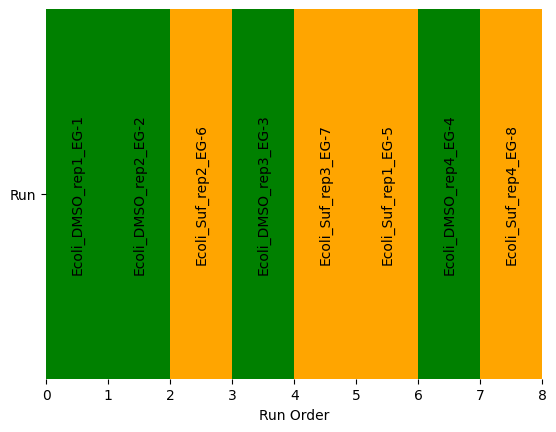

In [7]:
ax = pd.DataFrame({v:1 for v in mzqc_df.date_order.values}, index=['Run'])\
    .plot.barh(stacked=True, xlabel='Run Order', legend=False, width=1,
          color=mzqc_df.sort_values(by=['date_order']).group.replace({'DMSO':'green','Suf':'orange'}).values)

for c,n in zip(ax.containers,mzqc_df.sort_values(by=['date_order']).index.values):
    labels = [n]
    ax.bar_label(c, labels=labels, label_type='center',rotation=90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(x=0,y=0,tight=True)
ax.set_ylim(-0.5,0.5)

## Check if the QC metric parameters reflect the experiment grouping
With mzQC we can produce a data frame with ease as seen before, and can subsequently use that data frame to directly perform data analysis by.
Here, we do so with a quick PCA on the metric values, excluding the `group` since we want to use this as independent parameter to color by, and `date order` since as a index sequence it has no relevant information. 
Of course, we have to remove columns informing on the grouping first, as well as the identifications metric related columns, as these will likely introduce bias given that the study hypothesis holds true (i.e. sulforaphane changes the protein expression of E. coli).

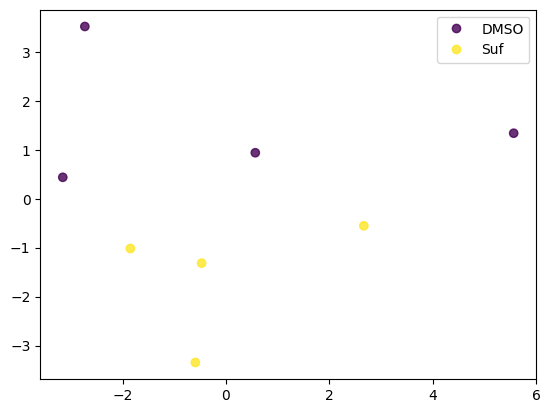

In [8]:
# %pip install scikit-learn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = mzqc_df.loc[:, mzqc_df.columns.drop(list(mzqc_df.filter(regex='^id_|num_mc|group|date_order')))].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
pca_values = pca.fit_transform(x)

pca_df = pd.DataFrame(data = pca_values, index=mzqc_df.index,
                      columns = ['principal component 1', 'principal component 2'])

labels, index = np.unique(mzqc_df.group, return_inverse=True)
fig, ax = plt.subplots()
sc = ax.scatter(pca_df['principal component 1'], pca_df['principal component 2'], marker = 'o', c = index, cmap = 'viridis', alpha = 0.8)
ax.legend(sc.legend_elements()[0], labels)
plt.show()

## Heatmap of the raw metric values
One run of the control group could be suspected to be an outlier measurement (Figure above, left-most DMSO datum). 
To further investigate, we will first compare the runs' metric values across the observed value range with a clustered heatmap to find out more about the value distribution of the individual metrics for this experiment. Therefore, we will scale the metric values to percentile rank values (i.e. scale each column to [0,1]) for color gradient mapping (i.e. a heatmap).

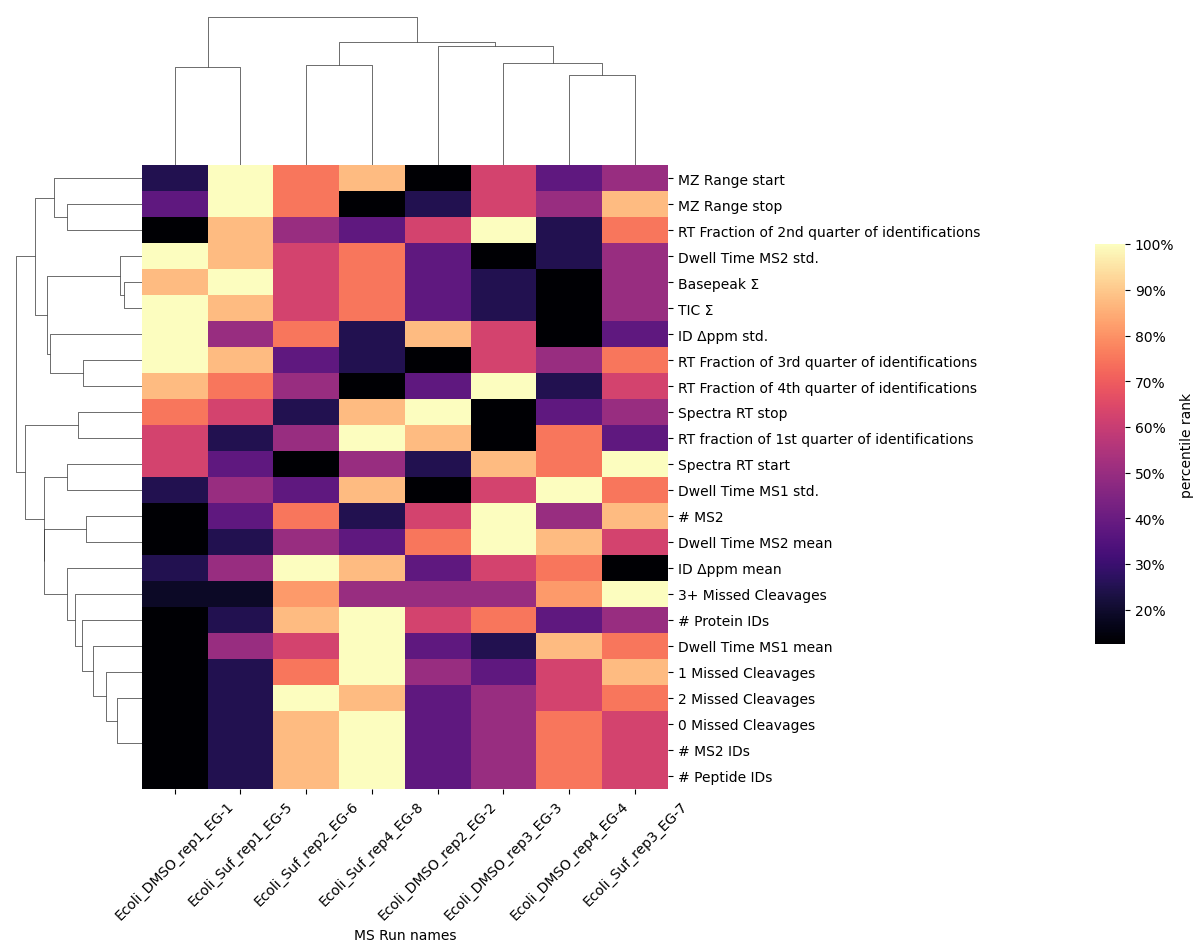

In [9]:
# %pip install seaborn 
import seaborn as sns
from matplotlib import ticker

hmdf = mzqc_df.drop(['date_order', 'group'], axis=1).rename(columns = {
                     "mz_range": "MZ Range", 
                     "rt_range": "RT Range",
                     "basepeakintensities_sum": "Basepeak Σ",
                     "ticintensities_sum": "TIC Σ",
                     "MS1_ict_mean": "Dwell Time MS1 mean",
                     "MS1_ict_std": "Dwell Time MS1 std.",
                     "MS2_ict_mean": "Dwell Time MS2 mean",
                     "MS2_ict_std": "Dwell Time MS2 std.",
                     "num_MS2": "# MS2",
                     "num_id_MS2": "# MS2 IDs",
                     "id_pep": "# Peptide IDs",
                     "id_prot": "# Protein IDs",
                     "id_dppm_mean": "ID Δppm mean",
                     "id_dppm_std": "ID Δppm std.",
                     "id_1stq_rtfrac": "RT fraction of 1st quarter of identifications",
                     "id_2ndq_rtfrac": "RT Fraction of 2nd quarter of identifications",
                     "id_3rdq_rtfrac": "RT Fraction of 3rd quarter of identifications",
                     "id_4thq_rtfrac": "RT Fraction of 4th quarter of identifications",
                     "rt_min": "Spectra RT start",
                     "rt_max": "Spectra RT stop",
                     "0 mc": "0 Missed Cleavages",
                     "1 mc": "1 Missed Cleavages", 
                     "2 mc": "2 Missed Cleavages", 
                     "3+ mc": "3+ Missed Cleavages",
                     "mz_min": "MZ Range start",
                     "mz_max": "MZ Range stop",
                    })
hmdf.index.name = "MS Run names"
plot = sns.clustermap(hmdf.rank(pct=True).T, cmap="magma",
                      cbar_kws={'label': "percentile rank", 'format': ticker.PercentFormatter(xmax=1)},
                      cbar_pos=(1.1, .35, .03, .4)
                      ).tick_params(axis='x', rotation=45)

# sns.move_legend(plot, "lower right", )

# rotated axis labels can't be aligned with seaborn
# import matplotlib.pyplot as plt
# plt.setp(plot.get_xticklabels(), axis='x', rotation=45, ha='right', rotation_mode='anchor')

plot.savefig('heatmap.svg', dpi=600)

We see that both DMSO and Suf groups cluster in the lower half of the heatmap, though one DMSO run (EG1) seems to be closer to one of the Suf runs (EG5). The upper half of the heatmap is clustered less clear, except  for one DMSO run (again EG1). One reason might be that the metric values are considered face-value without further context in this map.

1870.2857142857142


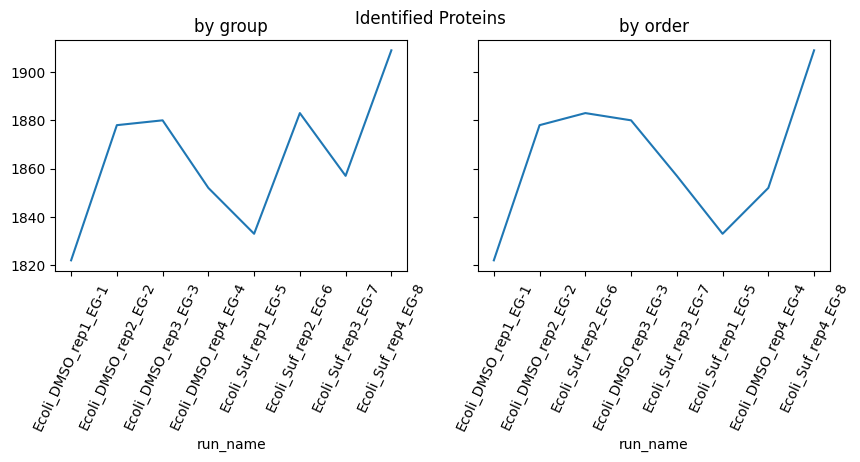

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Identified Proteins')

mzqc_df.id_prot.plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
mzqc_df.sort_values(by=['date_order']).id_prot.plot.line(ax=ax2, title="by order").tick_params(axis='x', rotation=65)

print(mzqc_df.drop('Ecoli_DMSO_rep1_EG-1',axis=0).id_prot.mean())

With this in mind, we look first at the number of identified proteins in each run, and match it against our expectation. 
We first visualise by experimental group (left), then by order of acquisition (right) to possibly detect ant influence of the run order or grouping towards the identification.
Immediately recognizable is the first run (EG1) with the lowest number of proteins covered. 
In addition, an upward trend may be recognised (stronger in order of acquisition, right). 
In general, even when excluding the first DMSO run (EG1), the number of identified Proteins is still low (average 1320).
This points toward an optimisation potential for the identification input parameters.
An influence of the run order towards the identification seems unlikely with the exception of EG1, which cannot be investigated with the data at hand.
Here, longitudinal QC measurements (generalised instrument performance before, after and maybe even in-between the study's runs) are usually a great help to categorise the data further.


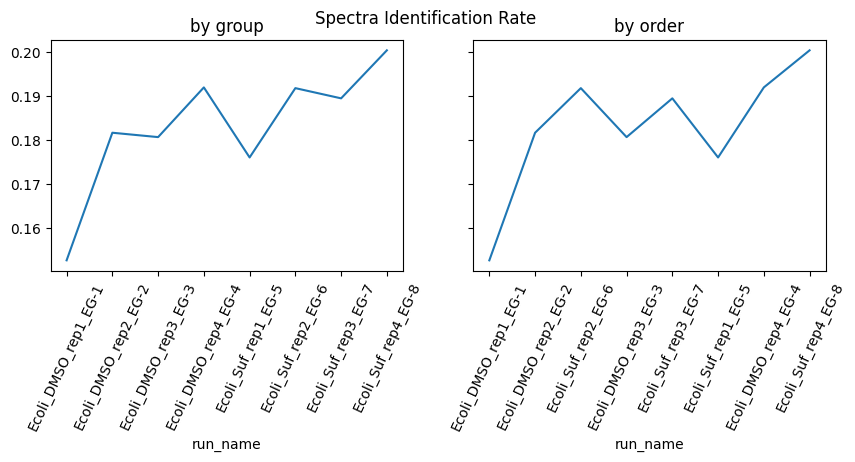

In [11]:
# ax = mzqc_df[["num_id_MS2", "num_MS2"]].plot.line().tick_params(axis='x', rotation=35)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Spectra Identification Rate')

(mzqc_df['num_id_MS2']/(mzqc_df['num_MS2'])).plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
(mzqc_df.sort_values(by=['date_order'])['num_id_MS2']/(mzqc_df.sort_values(by=['date_order'])['num_MS2'])).plot.line(ax=ax2, title="by order").tick_params(axis='x', rotation=65)

Similarly, we look at the spectra identification ratio. 
Here, we'd expect in a good case a quarter to half of the spectra recorded to be identified.
We notice that actually less than a 5th of the MS2 spectra are identified. 
An influence of the run order towards the identification ratio seems less likely than in the previous plot with the number of identified proteins.
In fact, the group separation is relatively well pronounced for the spectra identification ratio.

We also notice, that the ratio for the first run (EG1) is among the highest values. 
Low identification numbers, but a strong identification ratio in EG1 leads us to assume the outlier effects seen from EG1 originate for a reason different than the sample's contents.
A low number of MS2 with a good ratio identifiable can be due to issues with the sample type itself.
However, given the fact that the other runs in the group show a different pattern, there may have been issues with the isolation and collection of sufficient amounts of precursor ions for successful framgentation and subsequent identification in that particular run.

One reason for the latter may be the insufficient utilisation of ion collection time or great levels of (chemical) noise. 
Therefore, we inspect the mean ion collection times for MS1 first.
We see that the survey scans are fairly close in their mean ion collection time, with a loose clustering at the group level, without hints of influence by the acquisition order. 

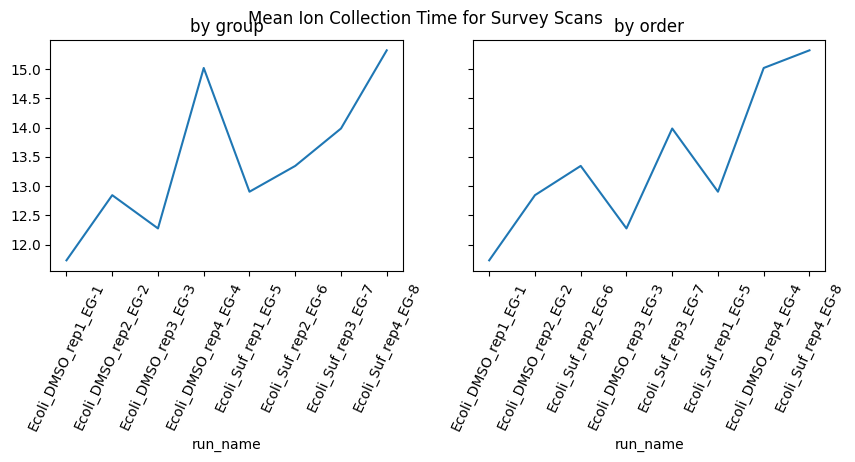

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Mean Ion Collection Time for Survey Scans')

mzqc_df['MS1_ict_mean'].plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
mzqc_df.sort_values(by=['date_order'])['MS1_ict_mean'].plot.line(ax=ax2, title = "by order").tick_params(axis='x', rotation=65)

Inspecting the MS2 mean ion collection time, we see a similar difference between the means for each group and also the survey scans.
There are also no hints of acquisition-order influence.
However, the 'first' runs of each group (EG1/EG5) have a markedly lower collection time than the rest of the group. 
This is less pronounced for the Suf group (EG5) and likely inconsequential since it is not connected to any other shortfalls in EG5.
For EG1 this strengthens the case for treating it as an outlier.
> The lower amount of time spent collecting both MS1 and MS2 might speak to a problem with non-protein contaminants?  
> machine presets: Q-Exactive+, 375–1800 m/z, MS1 maximal injection time of 50 ms, AGC maximum 3*10^6, reso­lution of 70 k, MS2 20 MS/MS HCD scans, (NCE? of 28;32;38,) maximal injection time of 60 ms, AGC maximum 2*10^5, resolution of 17.5 k. Data analysis with MaxQuant (v1.6.17.0) and Perseus.

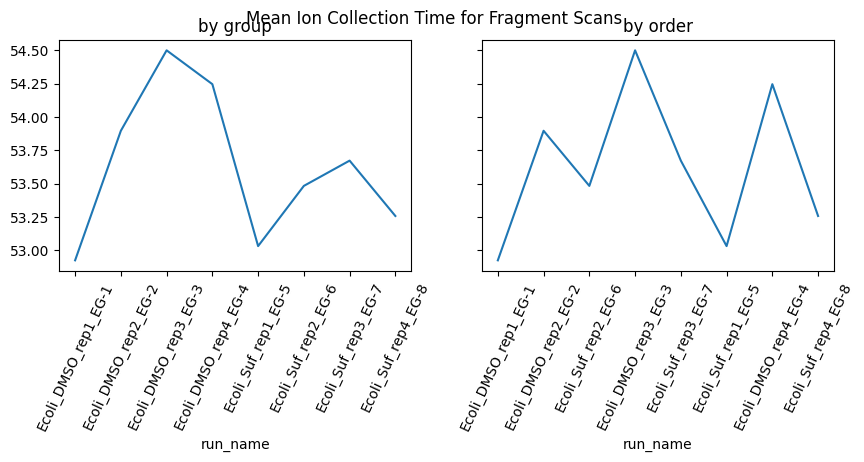

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10,3))
fig.suptitle('Mean Ion Collection Time for Fragment Scans')

mzqc_df['MS2_ict_mean'].plot.line(ax=ax1, title = "by group").tick_params(axis='x', rotation=65)
mzqc_df.sort_values(by=['date_order'])['MS2_ict_mean'].plot.line(ax=ax2, title = "by order").tick_params(axis='x', rotation=65)

We can look for further evidence of a contamination issue by looking at how the signal(s) were utilised. 
Available are the basepeak intensities together with the summed total ion count intensities.
We first look at how the two values compare (left) and then observe the ratio of basepeak intensities sums and total ion count intensities.
Here again the first run (EG1) appears to go against the trend, acquisition order interference can be discarded (not shown).   
Though a lot of signal was registered at the base peaks, the amount of ion signal that can be processed was less in EG1 when compared to the other runs, pointing towards an issue with the sample measured or the ionisation working improperly. 
> Since there are fewer MS2 in EG1 than in all other runs, we think it is no ionisation issue though that is one of the common issues with failing runs, but rather some other trivial issue like accidental dilution or the sample sitting for too long sample containers, pepetides precipitating against the container walls. Or some such.

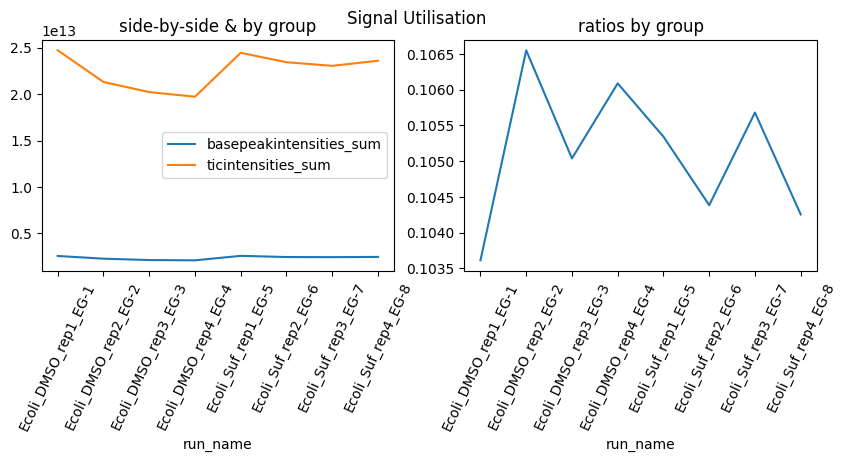

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,3))
fig.suptitle('Signal Utilisation')

(mzqc_df[['basepeakintensities_sum','ticintensities_sum']]).plot.line(ax=ax1, title = "side-by-side & by group").tick_params(axis='x', rotation=65)
# (mzqc_df['ticintensities_sum']/mzqc_df['basepeakintensities_sum']/1e-1).plot.line(ax=ax2, title = "ratios by group").tick_params(axis='x', rotation=65)
(mzqc_df['basepeakintensities_sum']/mzqc_df['ticintensities_sum']).plot.line(ax=ax2, title = "ratios by group").tick_params(axis='x', rotation=65)

## TICs 
To round things off, lets plot the TICs of the runs. Specifically, contrast run EG1 against all other runs of the study. 

In [15]:
tics = []
for run in mzqcobj.runQualities:
    sws = [sw.name for sw in run.metadata.analysisSoftware]
    if 'custom unreleased software tool' in sws and not 'mzR' in sws:
        tics.append(pd.DataFrame(next(iter([cd.value for cd in run.qualityMetrics if cd.accession=="MS:4000104"]))).assign(run=base_run_name(run.metadata.inputFiles)))
        # .astype('float')
tics_df = pd.concat(tics)
tics_df

,MS:1000285,MS:1000894,MS:1000767,MS:1003059,run
0,15670053.0,360.17908,scan=controllerType=0 controllerNumber=1 scan=1,741,20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1
1,15076560.0,360.53033,scan=controllerType=0 controllerNumber=1 scan=2,747,20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1
2,15442671.0,360.88705,scan=controllerType=0 controllerNumber=1 scan=3,776,20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1
3,15162215.0,361.23820,scan=controllerType=0 controllerNumber=1 scan=4,746,20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1
4,15373149.0,361.58917,scan=controllerType=0 controllerNumber=1 scan=5,728,20220830_JL-4884_Forster_Ecoli_DMSO_rep1_EG-1
...,...,...,...,...,...
8379,11454000.0,7498.91100,scan=controllerType=0 controllerNumber=1 scan=...,1110,20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8
8380,12146284.0,7499.26200,scan=controllerType=0 controllerNumber=1 scan=...,1112,20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8
8381,12194630.0,7499.61430,scan=controllerType=0 controllerNumber=1 scan=...,1095,20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8
8382,12615527.0,7499.96530,scan=controllerType=0 controllerNumber=1 scan=...,1179,20220830_JL-4884_Forster_Ecoli_Suf_rep4_EG-8


Text(0, 0.5, 'Intensity[counts]')

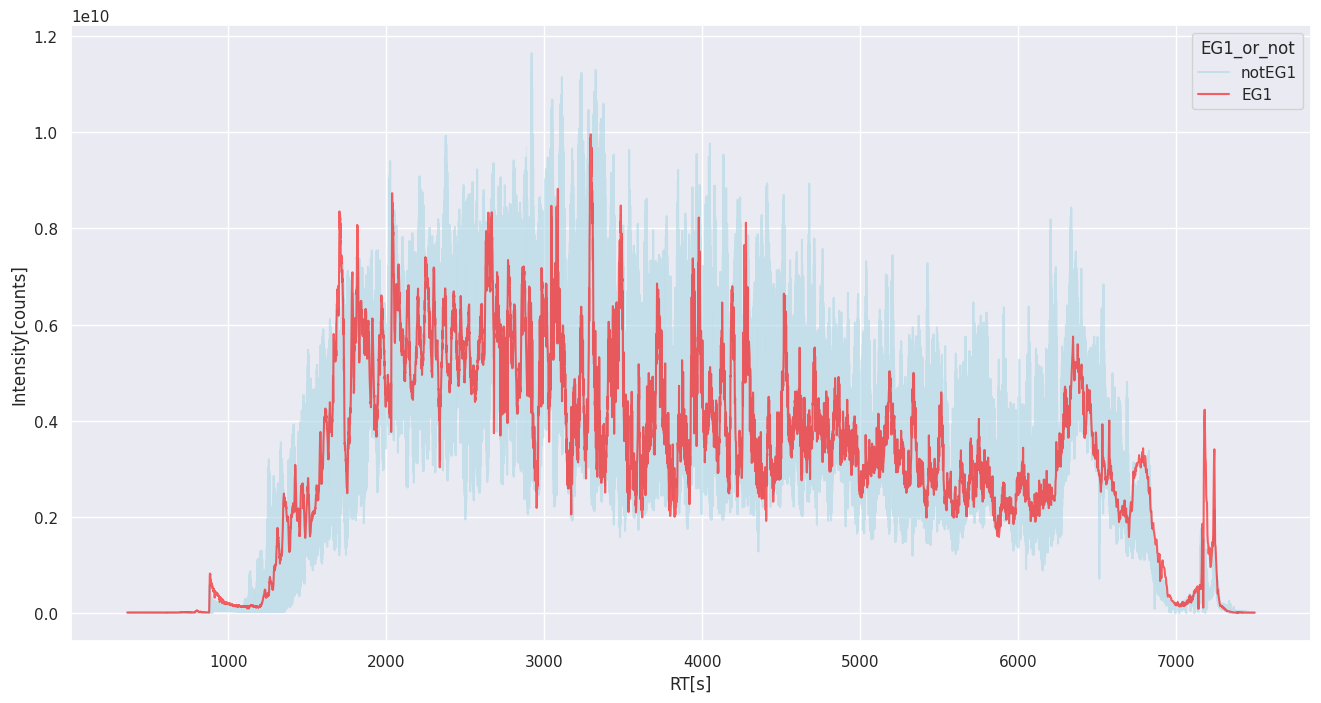

In [16]:
tics_df.run = tics_df.run.str.removeprefix("20220830_JL-4884_Forster_")
tics_df['EG1_or_not'] = np.where(tics_df.run.str.endswith('1'),'EG1', 'notEG1')
tics_df['EG1_or_not'] = tics_df['EG1_or_not'].astype("category")
tics_df

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.lineplot(data=tics_df, x='MS:1000894', y='MS:1000285', hue="EG1_or_not", palette=['lightblue','red'], hue_order=['notEG1','EG1'], alpha=0.6)
ax.set_xlabel("RT[s]")
ax.set_ylabel("Intensity[counts]")


## Conclusion 
In short: we would probably re-run EG1, at least treating it as an outlier (which their quantification rule set for proteins present in at least 3 measurements served for)

We can look at the quality of the experiment from a different perspective as we did briefly before by checking against expected results (as informed by previous runs, experience, limiting input factors, etc.) 
We therefore shape the QC metric values into a set of ratios to form a value between 0 and 100 from which we can easily gauge a run standing on its own and just as easy apply acceptance limits, which for this example __could be better informed__. 
 * The acquisition time, scaled by the gradient length setting (i.e. 7500 sec is 100%)
 * The injection times with a fixed lower limit as 0% - 50ns as per instrument settings
 * The mean of missed cleavages, with a fixed lower limit of any value > 1 and upper limit of 0 missed cleavages representing 100% (mc setting is 3 but we 'arbitrarily' set the acceptable limit of mean missed cleavages in a run to < 1)
 * For the spectra identification ratio, we set our expectations for a good run (i.e. 100%) to be at a quarter of spectra identified (1:4 ratio)
 * The longest stretch of acquisition time during which identifications were made scaled against the complete acquisition time
 * The mean identification mass accuracy (in dppm), with a fixed lower limit of any > 20 abs(deltaPPM) as 0%.
 * protein coverage, targeting to cover 1000 proteins (100%) w/ these settings seems reasonable?
 * peptide oversampling, the percentage of peptides sampled (successfully) more than once
